## LSTM using Closing Price
### All-in-one Approach (5.2 from report)

Anastasios Koutsogiannopoulos, 03321

Fani Banou, 03322

Ioannis Sakellariou, 03144

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive


### Data Processing

In [ ]:
def mount_drive():
    """Mounts Google Drive for dataset access."""
    drive.mount('/content/drive')

In [ ]:
def load_data(file_path):
    """Loads the dataset from the given file path."""
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['unix'], unit='s')
    data.set_index('date', inplace=True)
    data = data.sort_index(ascending=True)
    return data

In [ ]:
def resample_data(data, time):
    """Resamples the data based on the specified time interval."""
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    if time == 0:
        return numeric_data  # Minute-level data
    elif time == 1:
        return numeric_data.resample('1h').mean()  # Hourly data
    elif time == 2:
        return numeric_data.resample('1d').mean()  # Daily data
    else:
        raise ValueError("Invalid 'time' value. Choose 0 (minute), 1 (hourly), or 2 (daily).")


In [ ]:
def scale_and_split_data(data, train_end_date, test_start_date, test_end_date):
    """Scales and splits the dataset into train and test sets."""
    data = data[['close']].dropna()

    train_data = data[:train_end_date]
    test_data = data[test_start_date:test_end_date]

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    train_scaled = pd.DataFrame(train_scaled, index=train_data.index, columns=train_data.columns)
    test_scaled = pd.DataFrame(test_scaled, index=test_data.index, columns=test_data.columns)

    return train_scaled, test_scaled, scaler

In [ ]:
def create_dataset(data, time_step, forecast_horizon):
    """Creates sliding windows for input (X) and corresponding multi-step targets (y)."""
    X, y = [], []
    for i in range(len(data) - time_step - forecast_horizon + 1):
        X.append(data.iloc[i:i + time_step].values)
        y.append(data.iloc[i + time_step:i + time_step + forecast_horizon, 0].values)

    return np.array(X), np.array(y)

### LSTM Model

In [ ]:
def get_model(X_train, forecast_horizon):
    """Returns a compiled LSTM model."""
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(forecast_horizon)  # Fixed variable issue
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

###  Training

In [ ]:
def train_model(X_train, y_train, epochs, patience, batch_size, forecast_horizon):
    """Trains the LSTM model."""
    model = get_model(X_train, forecast_horizon)

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping],
        shuffle=False
    )

    return model, history

### Prediction & Evaluation

In [ ]:
def forecast(model, last_window):
    """Generates forecasts using the trained model."""
    input_seq_reshaped = last_window.reshape(1, last_window.shape[0], 1)
    return model.predict(input_seq_reshaped, verbose=0)[0]


In [ ]:
def predict_and_evaluate_model(model, X_test, y_test, scaler, dates):
    """Generates predictions, evaluates the model, and plots results."""
    predictions = forecast(model, X_test)

    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)

    print(f"\nSingle Run Results")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plot_forecast(y_test_rescaled, predictions_rescaled, dates, title="Bitcoin Price Prediction (Single Run)")


In [ ]:
def plot_forecast(y_true, y_pred, dates, title="Forecast vs True Prices"):
    """Plots actual vs predicted prices with correct date labels."""
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Prices', color='blue')
    plt.plot(dates, y_pred, label='Predicted Prices', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
def plot_loss(history):
    """Plots training & validation loss curves."""
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Multi-Run Experiment

In [ ]:
def run_multiple_experiments(num_runs, X_train, y_train, X_test, y_test, dates, scaler, batch_size, forecast_horizon):
    """Runs multiple experiments and averages the results."""
    mse_list, mae_list = [], []
    predictions_list, histories = [], []
    min_epochs = float('inf')
    train_times = []         # To store execution times for model training
    predict_times = []      # To store execution times for predict
    loss_list, val_loss_list = [], []
    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        start_time = time.time()
        model, history = train_model(X_train, y_train, epochs=100, patience=15, batch_size=batch_size, forecast_horizon=forecast_horizon)
        train_time = time.time() - start_time
        train_times.append(train_time)

        min_epochs = min(min_epochs, len(history.history['loss']))
        histories.append(history)
        loss_list.append(history.history['loss'])
        val_loss_list.append(history.history['val_loss'])

        start_time = time.time()
        predictions = forecast(model, X_test)
        predict_time = time.time() - start_time
        predict_times.append(predict_time)

        predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

        mse_list.append(mean_squared_error(y_test_rescaled, predictions_rescaled))
        mae_list.append(mean_absolute_error(y_test_rescaled, predictions_rescaled))

        predictions_list.append(predictions_rescaled)

    avg_predictions = np.mean(np.array(predictions_list), axis=0)
    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    loss_array = np.array([l[:min_epochs] for l in loss_list])
    val_loss_array = np.array([v[:min_epochs] for v in val_loss_list])

    avg_loss = np.mean(loss_array, axis=0)
    avg_val_loss = np.mean(val_loss_array, axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(avg_loss, label="Average Training Loss")
    plt.plot(avg_val_loss, label="Average Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Average Loss Curves over {num_runs} Runs")
    plt.legend()
    plt.show()

    plot_forecast(y_test_rescaled, avg_predictions, dates, title=f'Average Forecast ({num_runs} Runs)')

    print(f"\nAverage MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}")

    #  Compute and print average execution times
    avg_train_time = np.mean(train_times)
    avg_predict_time = np.mean(predict_times)
    print(f"\nAverage Execution Times over {num_runs} Runs:")
    print(f"Model Training Time: {avg_train_time:.4f} seconds")
    print(f"Predicting Time: {avg_predict_time:.4f} seconds")


###  Main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1938 - mae: 0.3669 - val_loss: 0.0601 - val_mae: 0.1911
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0844 - mae: 0.2393 - val_loss: 0.0206 - val_mae: 0.1146
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0466 - mae: 0.1777 - val_loss: 0.0295 - val_mae: 0.1487
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0297 - mae: 0.1349 - val_loss: 0.0230 - val_mae: 0.1289
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0260 - mae: 0.1257 - val_loss: 0.0202 - val_mae: 0.1201
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0243 - mae: 0.1211 - val_loss: 0.0188 - val_mae: 0.1154
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229 - mae: 0.1171 - val_loss: 0.0162 - val_mae: 0.1069
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0218 - mae: 0.1136 - val_loss: 0.0132 - val_mae: 0.0958
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0200 -

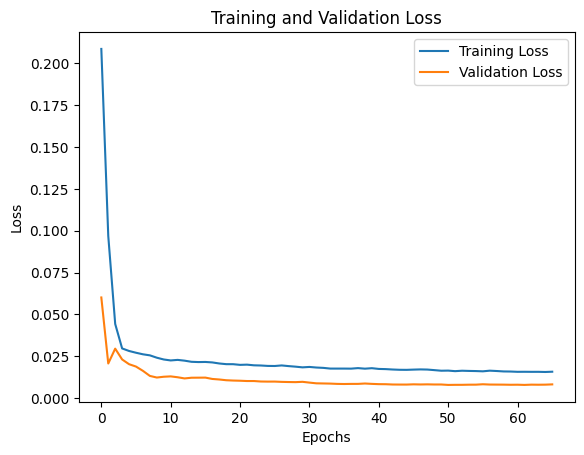


Single Run Results
MAE: 2214.2411
MSE: 6599357.8847
RMSE: 2568.9215


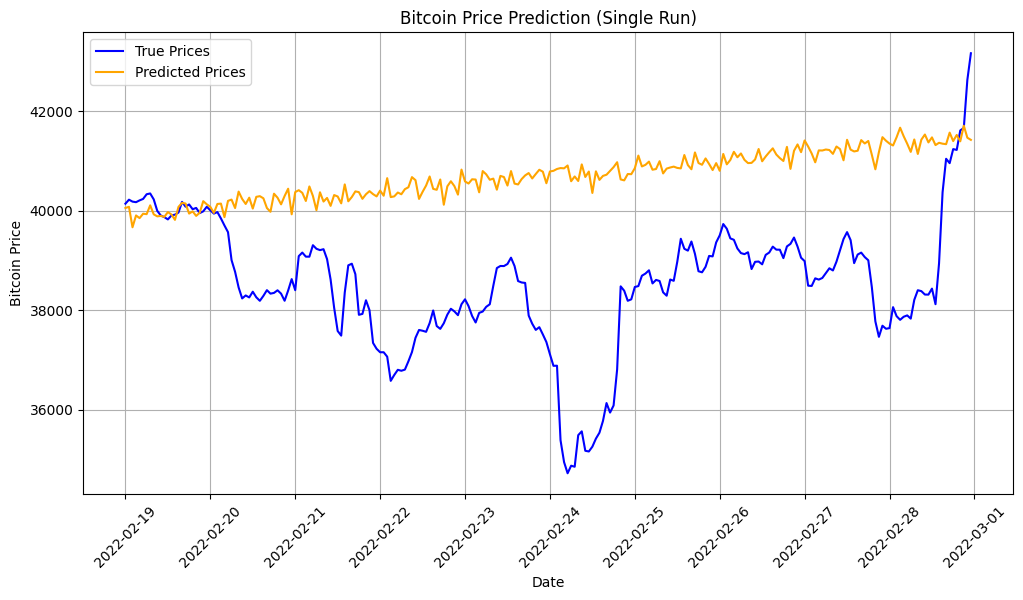


Running Multiple Experiments...
Run 1/10
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1967 - mae: 0.3718 - val_loss: 0.0595 - val_mae: 0.1924
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0912 - mae: 0.2482 - val_loss: 0.0246 - val_mae: 0.1258
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0699 - mae: 0.2299 - val_loss: 0.0211 - val_mae: 0.1178
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0715 - mae: 0.2297 - val_loss: 0.0195 - val_mae: 0.1139
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0446 - mae: 0.1782 - val_loss: 0.0705 - val_mae: 0.2357
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0642 - mae: 0.1951 - val_loss: 0.0309 - val_mae: 0.1540
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0249 - mae: 0.1238 - val_loss: 0.0334 - val_mae: 0.1613
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0293 - mae: 0.1327 - val_loss: 0.0150 - val_mae: 0.1023
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0202 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1938 - mae: 0.3686 - val_loss: 0.0545 - val_mae: 0.1849
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0922 - mae: 0.2496 - val_loss: 0.0257 - val_mae: 0.1281
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0714 - mae: 0.2314 - val_loss: 0.0215 - val_mae: 0.1202
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0735 - mae: 0.2345 - val_loss: 0.0214 - val_mae: 0.1202
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0722 - mae: 0.2334 - val_loss: 0.0214 - val_mae: 0.1200
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0721 - mae: 0.2336 - val_loss: 0.0214 - val_mae: 0.1198
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0722 - mae: 0.2333 - val_loss: 0.0212 - val_mae: 0.1194
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0698 - mae: 0.2302 - val_loss: 0.0207 - val_mae: 0.1175
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0605 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1894 - mae: 0.3624 - val_loss: 0.0634 - val_mae: 0.1977
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0940 - mae: 0.2519 - val_loss: 0.0258 - val_mae: 0.1288
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0719 - mae: 0.2311 - val_loss: 0.0215 - val_mae: 0.1202
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0680 - mae: 0.2277 - val_loss: 0.0232 - val_mae: 0.1219
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0574 - mae: 0.2023 - val_loss: 0.0302 - val_mae: 0.1514
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0361 - mae: 0.1504 - val_loss: 0.0316 - val_mae: 0.1550
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0258 - mae: 0.1247 - val_loss: 0.0270 - val_mae: 0.1430
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0273 - mae: 0.1283 - val_loss: 0.0148 - val_mae: 0.1016
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0209 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1935 - mae: 0.3683 - val_loss: 0.0599 - val_mae: 0.1912
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0731 - mae: 0.2188 - val_loss: 0.0800 - val_mae: 0.2562
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0596 - mae: 0.1915 - val_loss: 0.0498 - val_mae: 0.2025
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0297 - mae: 0.1343 - val_loss: 0.0294 - val_mae: 0.1506
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0308 - mae: 0.1389 - val_loss: 0.0193 - val_mae: 0.1182
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0268 - mae: 0.1291 - val_loss: 0.0145 - val_mae: 0.1002
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0237 - mae: 0.1199 - val_loss: 0.0108 - val_mae: 0.0856
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0205 - mae: 0.1095 - val_loss: 0.0103 - val_mae: 0.0832
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0187 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.1901 - mae: 0.3634 - val_loss: 0.0514 - val_mae: 0.1783
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0811 - mae: 0.2375 - val_loss: 0.0229 - val_mae: 0.1225
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0531 - mae: 0.1935 - val_loss: 0.0198 - val_mae: 0.1183
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0301 - mae: 0.1377 - val_loss: 0.0189 - val_mae: 0.1169
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0251 - mae: 0.1234 - val_loss: 0.0145 - val_mae: 0.1025
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0213 - mae: 0.1115 - val_loss: 0.0136 - val_mae: 0.0981
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0197 - mae: 0.1071 - val_loss: 0.0154 - val_mae: 0.1044
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0200 - mae: 0.1086 - val_loss: 0.0156 - val_mae: 0.1046
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0203 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.2002 - mae: 0.3750 - val_loss: 0.0676 - val_mae: 0.2042
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0796 - mae: 0.2275 - val_loss: 0.0926 - val_mae: 0.2785
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0605 - mae: 0.1912 - val_loss: 0.0582 - val_mae: 0.2221
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0308 - mae: 0.1361 - val_loss: 0.0436 - val_mae: 0.1898
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0306 - mae: 0.1375 - val_loss: 0.0277 - val_mae: 0.1453
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0288 - mae: 0.1341 - val_loss: 0.0185 - val_mae: 0.1148
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0253 - mae: 0.1238 - val_loss: 0.0129 - val_mae: 0.0942
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0216 - mae: 0.1128 - val_loss: 0.0114 - val_mae: 0.0883
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0188 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1987 - mae: 0.3724 - val_loss: 0.0714 - val_mae: 0.2127
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0861 - mae: 0.2365 - val_loss: 0.0300 - val_mae: 0.1439
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0541 - mae: 0.1915 - val_loss: 0.0238 - val_mae: 0.1312
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0302 - mae: 0.1368 - val_loss: 0.0156 - val_mae: 0.1042
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0252 - mae: 0.1233 - val_loss: 0.0132 - val_mae: 0.0968
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0218 - mae: 0.1124 - val_loss: 0.0125 - val_mae: 0.0930
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0201 - mae: 0.1084 - val_loss: 0.0147 - val_mae: 0.1010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0210 - mae: 0.1113 - val_loss: 0.0139 - val_mae: 0.0982
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0209 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1905 - mae: 0.3653 - val_loss: 0.0592 - val_mae: 0.1936
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0905 - mae: 0.2472 - val_loss: 0.0243 - val_mae: 0.1254
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0642 - mae: 0.2203 - val_loss: 0.0321 - val_mae: 0.1504
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0882 - mae: 0.2452 - val_loss: 0.0283 - val_mae: 0.1375
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0587 - mae: 0.2105 - val_loss: 0.0215 - val_mae: 0.1190
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0537 - mae: 0.1960 - val_loss: 0.0245 - val_mae: 0.1248
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0533 - mae: 0.1903 - val_loss: 0.0206 - val_mae: 0.1151
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0743 - mae: 0.2413 - val_loss: 0.0153 - val_mae: 0.0963
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0586 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1983 - mae: 0.3731 - val_loss: 0.0742 - val_mae: 0.2190
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0970 - mae: 0.2545 - val_loss: 0.0268 - val_mae: 0.1309
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0727 - mae: 0.2328 - val_loss: 0.0221 - val_mae: 0.1210
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0726 - mae: 0.2335 - val_loss: 0.0218 - val_mae: 0.1206
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0714 - mae: 0.2323 - val_loss: 0.0217 - val_mae: 0.1205
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0714 - mae: 0.2325 - val_loss: 0.0216 - val_mae: 0.1204
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0704 - mae: 0.2308 - val_loss: 0.0216 - val_mae: 0.1203
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0707 - mae: 0.2321 - val_loss: 0.0216 - val_mae: 0.1203
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0706 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1976 - mae: 0.3695 - val_loss: 0.0732 - val_mae: 0.2151
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0853 - mae: 0.2364 - val_loss: 0.0329 - val_mae: 0.1509
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0563 - mae: 0.1951 - val_loss: 0.0213 - val_mae: 0.1231
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0304 - mae: 0.1375 - val_loss: 0.0144 - val_mae: 0.0992
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0241 - mae: 0.1205 - val_loss: 0.0138 - val_mae: 0.0990
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0211 - mae: 0.1104 - val_loss: 0.0138 - val_mae: 0.0975
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0207 - mae: 0.1102 - val_loss: 0.0144 - val_mae: 0.1001
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0208 - mae: 0.1103 - val_loss: 0.0130 - val_mae: 0.0946
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0197 -

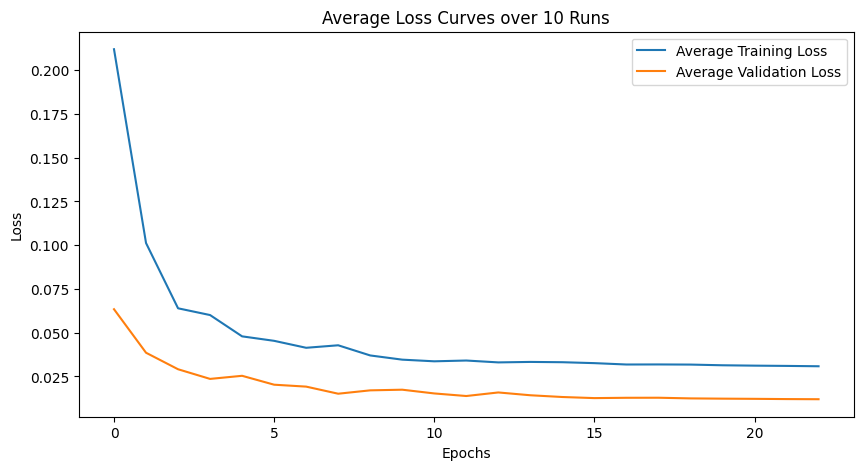

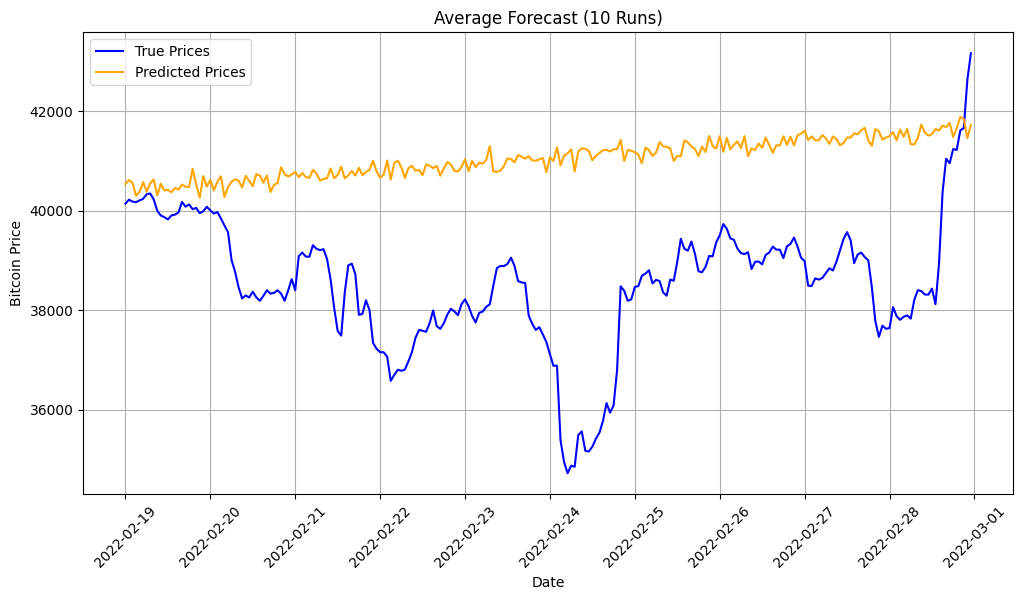


Average MSE: 10336230.8259, Average MAE: 2577.6335

Average Execution Times over 10 Runs:
Model Training Time: 63.3288 seconds
Predicting Time: 0.4144 seconds


In [ ]:
def main():
    mount_drive()
    file_path = '/content/drive/MyDrive/bitcoin-dataset.csv'

    data = load_data(file_path)
    data_resampled = resample_data(data, time=1)
    train_scaled, test_scaled, scaler = scale_and_split_data(data_resampled, '2022-02-18 23:59:59', '2022-02-19 00:00:00', '2022-02-28 23:59:59')

    window_size = 60
    forecast_horizon = len(test_scaled)

    X_train, y_train = create_dataset(train_scaled, window_size, forecast_horizon)
    X_test = train_scaled['close'].iloc[-window_size:].values
    y_test = test_scaled.iloc[:, 0].values
    dates = test_scaled.index[-len(y_test):]  # Dates for plotting

    model, history = train_model(X_train, y_train, epochs=100, patience=15, batch_size=256, forecast_horizon=forecast_horizon)
    plot_loss(history)
    predict_and_evaluate_model(model, X_test, y_test, scaler, dates)

    print("\nRunning Multiple Experiments...")
    run_multiple_experiments(10, X_train, y_train, X_test, y_test, dates, scaler, 256, forecast_horizon)

if __name__ == "__main__":
    main()